# Evaluation Method

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Load Model

In [2]:
output_df=pd.read_csv('sentiment_data/date_sentiments_finbert_pctv1_pctv2.csv')

In [3]:
output_df.sort_values(by='date', ascending=True, inplace=True)
display(output_df.head())
display(output_df.tail())

,date,sentiment1,sentiment2,sentiment3
0,2023-11-01,negative,positive,positive
1,2023-11-02,positive,positive,negative
2,2023-11-03,negative,positive,positive
3,2023-11-06,negative,neutral,neutral
4,2023-11-07,positive,positive,positive


,date,sentiment1,sentiment2,sentiment3
367,2025-04-24,neutral,positive,positive
368,2025-04-25,negative,positive,positive
369,2025-04-28,negative,positive,positive
370,2025-04-29,negative,positive,positive
371,2025-04-30,negative,positive,positive


### Choose Stock

In [4]:
stock = "NVDA"
stock_df = yf.download(stock, start="2023-01-01", end="2025-05-01", multi_level_index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
stock_df = stock_df['Close'].to_frame().reset_index()

display(stock_df.head())
display(stock_df.shape)

,Date,Close
0,2023-01-03,14.303281
1,2023-01-04,14.736923
2,2023-01-05,14.253321
3,2023-01-06,14.846835
4,2023-01-09,15.615205


(583, 2)

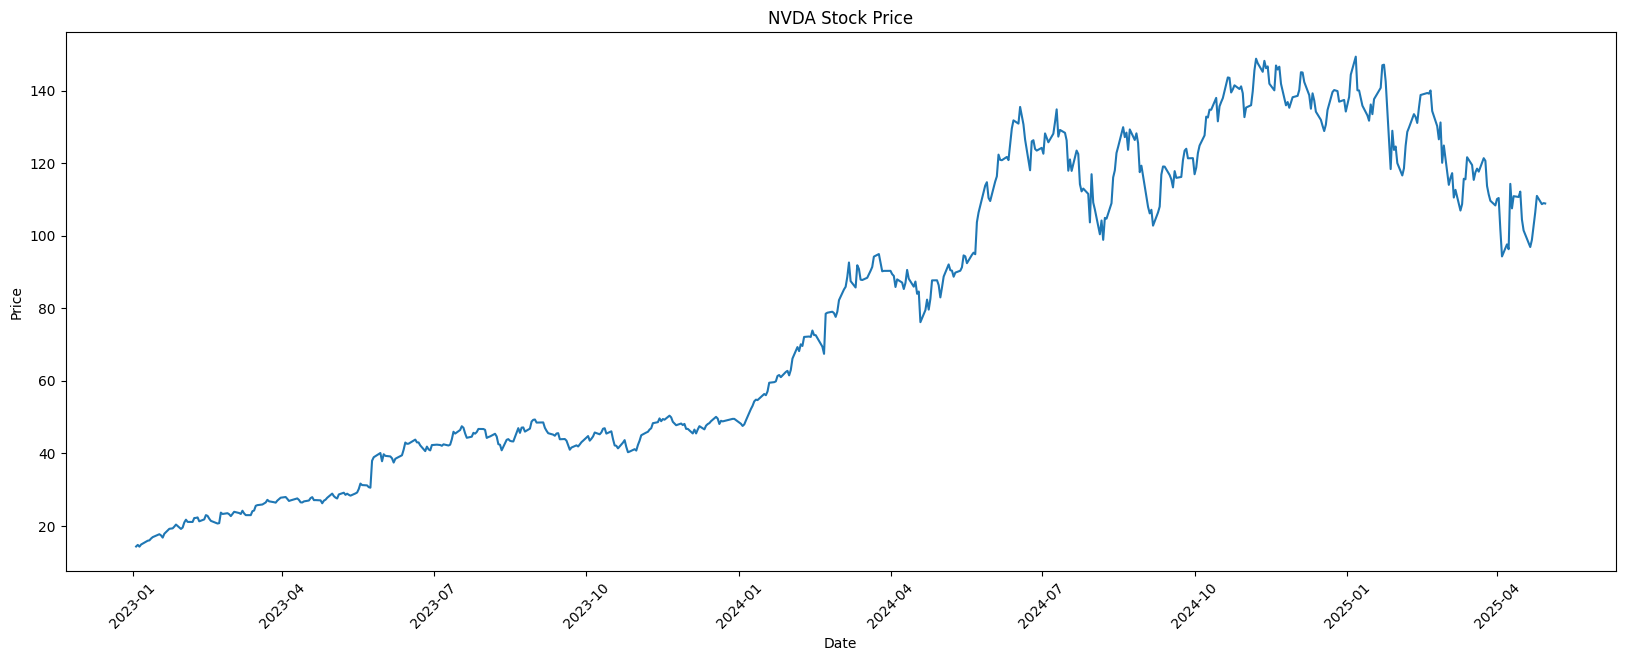

In [6]:
plt.figure(figsize=(20, 7))
plt.plot(stock_df['Date'], stock_df['Close'])
plt.title(f"{stock} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

In [7]:
stock_df['pct_change'] = stock_df['Close'].pct_change()
stock_df['pct_change'] = stock_df['pct_change'].shift(-1)
stock_df['pct_change'] = stock_df['pct_change'].fillna(0)
display(stock_df.head())
display(stock_df.tail())

,Date,Close,pct_change
0,2023-01-03,14.303281,0.030318
1,2023-01-04,14.736923,-0.032816
2,2023-01-05,14.253321,0.041640
3,2023-01-06,14.846835,0.051753
4,2023-01-09,15.615205,0.017981


,Date,Close,pct_change
578,2025-04-24,106.430000,0.043033
579,2025-04-25,111.010002,-0.020539
580,2025-04-28,108.730003,0.002667
581,2025-04-29,109.019997,-0.000917
582,2025-04-30,108.919998,0.000000


In [8]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
output_df['date'] = pd.to_datetime(output_df['date'])

In [9]:
#Merge the stock data with the model dataframes
df = pd.merge(output_df, stock_df, left_on='date', right_on='Date', how='left')

In [10]:
df.drop(columns=['Date'], inplace=True)

In [11]:
display(df.head())

,date,sentiment1,sentiment2,sentiment3,Close,pct_change
0,2023-11-01,negative,positive,positive,42.305397,0.027903
1,2023-11-02,positive,positive,negative,43.485844,0.034455
2,2023-11-03,negative,positive,positive,44.984150,0.016576
3,2023-11-06,negative,neutral,neutral,45.729801,0.004459
4,2023-11-07,positive,positive,positive,45.933712,0.013470


In [12]:
#change sentiment string to -1,0,1
def sentiment_to_numeric(sentiment):
    if sentiment == 'negative':
        return -1
    elif sentiment == 'neutral':
        return 0
    elif sentiment == 'positive':
        return 1
    else:
        return np.nan

df['sentiment1'] = df['sentiment1'].apply(sentiment_to_numeric)
df['sentiment2'] = df['sentiment2'].apply(sentiment_to_numeric)
df['sentiment3'] = df['sentiment3'].apply(sentiment_to_numeric)

In [13]:
df.dropna(inplace=True)
display(df.head())

,date,sentiment1,sentiment2,sentiment3,Close,pct_change
0,2023-11-01,-1,1,1,42.305397,0.027903
1,2023-11-02,1,1,-1,43.485844,0.034455
2,2023-11-03,-1,1,1,44.984150,0.016576
3,2023-11-06,-1,0,0,45.729801,0.004459
4,2023-11-07,1,1,1,45.933712,0.013470


## 1. Correlation

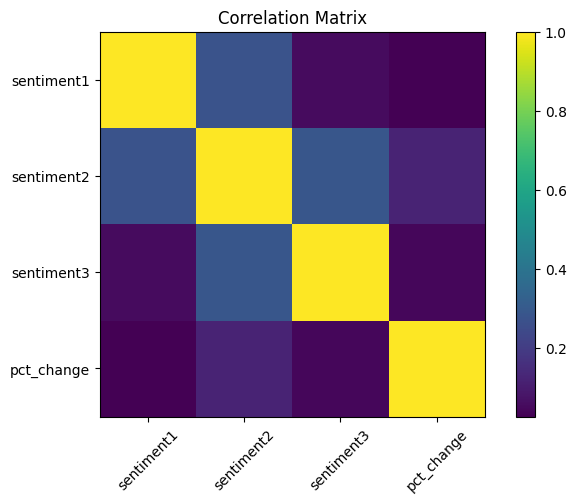

In [14]:
correlation_df=df[['sentiment1', 'sentiment2', 'sentiment3', 'pct_change']].copy()
correlation_df = correlation_df.corr()

plt.figure(figsize=(8, 5))
plt.title("Correlation Matrix")
plt.imshow(correlation_df, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_df.columns)), correlation_df.columns, rotation=45)
plt.yticks(range(len(correlation_df.columns)), correlation_df.columns)
plt.grid(False)
plt.show()

In [15]:
fig = px.imshow(correlation_df, text_auto=True, aspect="auto", color_continuous_scale='RdBu', title="Correlation Matrix")
fig.update_xaxes(title_text="Features")
fig.show()

## 2. Techincal Analysis

### Simple Moving Average

In [16]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

df['sma_signal'] = 0
df.loc[df['SMA_20'] > df['SMA_50'], 'sma_signal'] = 1
df.loc[df['SMA_20'] < df['SMA_50'], 'sma_signal'] = -1

### RSI

In [17]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

df['rsi_signal'] = 0
df.loc[df['RSI'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI'] > 70, 'rsi_signal'] = -1

### MACD

In [18]:
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

df['macd_signal_line'] = 0
df.loc[df['MACD'] > df['MACD_signal'], 'macd_signal_line'] = 1
df.loc[df['MACD'] < df['MACD_signal'], 'macd_signal_line'] = -1

### Bollinger Bands

In [19]:
bb = ta.volatility.BollingerBands(df['Close'])
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()

df['bb_signal'] = 0
df.loc[df['Close'] < df['bb_lower'], 'bb_signal'] = 1
df.loc[df['Close'] > df['bb_upper'], 'bb_signal'] = -1

In [20]:
df['sma_return']=df['sma_signal'].shift(1)*df['pct_change']
df['RSI_return']=df['rsi_signal'].shift(1)*df['pct_change']
df['MACD_return']=df['macd_signal_line'].shift(1)*df['pct_change']
df['BB_return']=df['bb_signal'].shift(1)*df['pct_change']

In [21]:
df['Next_Close'] = df['Close'].shift(-1)
df['Return'] = (df['Next_Close'] - df['Close']) / df['Close']

df['Strategy_Return_Model1'] = df['sentiment1'].shift(0) * df['Return']
df['Strategy_Return_Model2'] = df['sentiment2'].shift(0) * df['Return']
df['Strategy_Return_Model3'] = df['sentiment3'].shift(0) * df['Return']

df['Model1_Cumulative'] = (1 + df['Strategy_Return_Model1'].fillna(0)).cumprod()
df['Model2_Cumulative'] = (1 + df['Strategy_Return_Model2'].fillna(0)).cumprod()
df['Model3_Cumulative'] = (1 + df['Strategy_Return_Model3'].fillna(0)).cumprod()
df['BuyHold_Cumulative'] = (1 + df['Return'].fillna(0)).cumprod()
df['SMA_Cumulative'] = (1 + df['sma_return'].fillna(0)).cumprod()
df['RSI_Cumulative'] = (1 + df['RSI_return'].fillna(0)).cumprod()
df['MACD_Cumulative'] = (1 + df['MACD_return'].fillna(0)).cumprod()
df['BB_Cumulative'] = (1 + df['BB_return'].fillna(0)).cumprod()

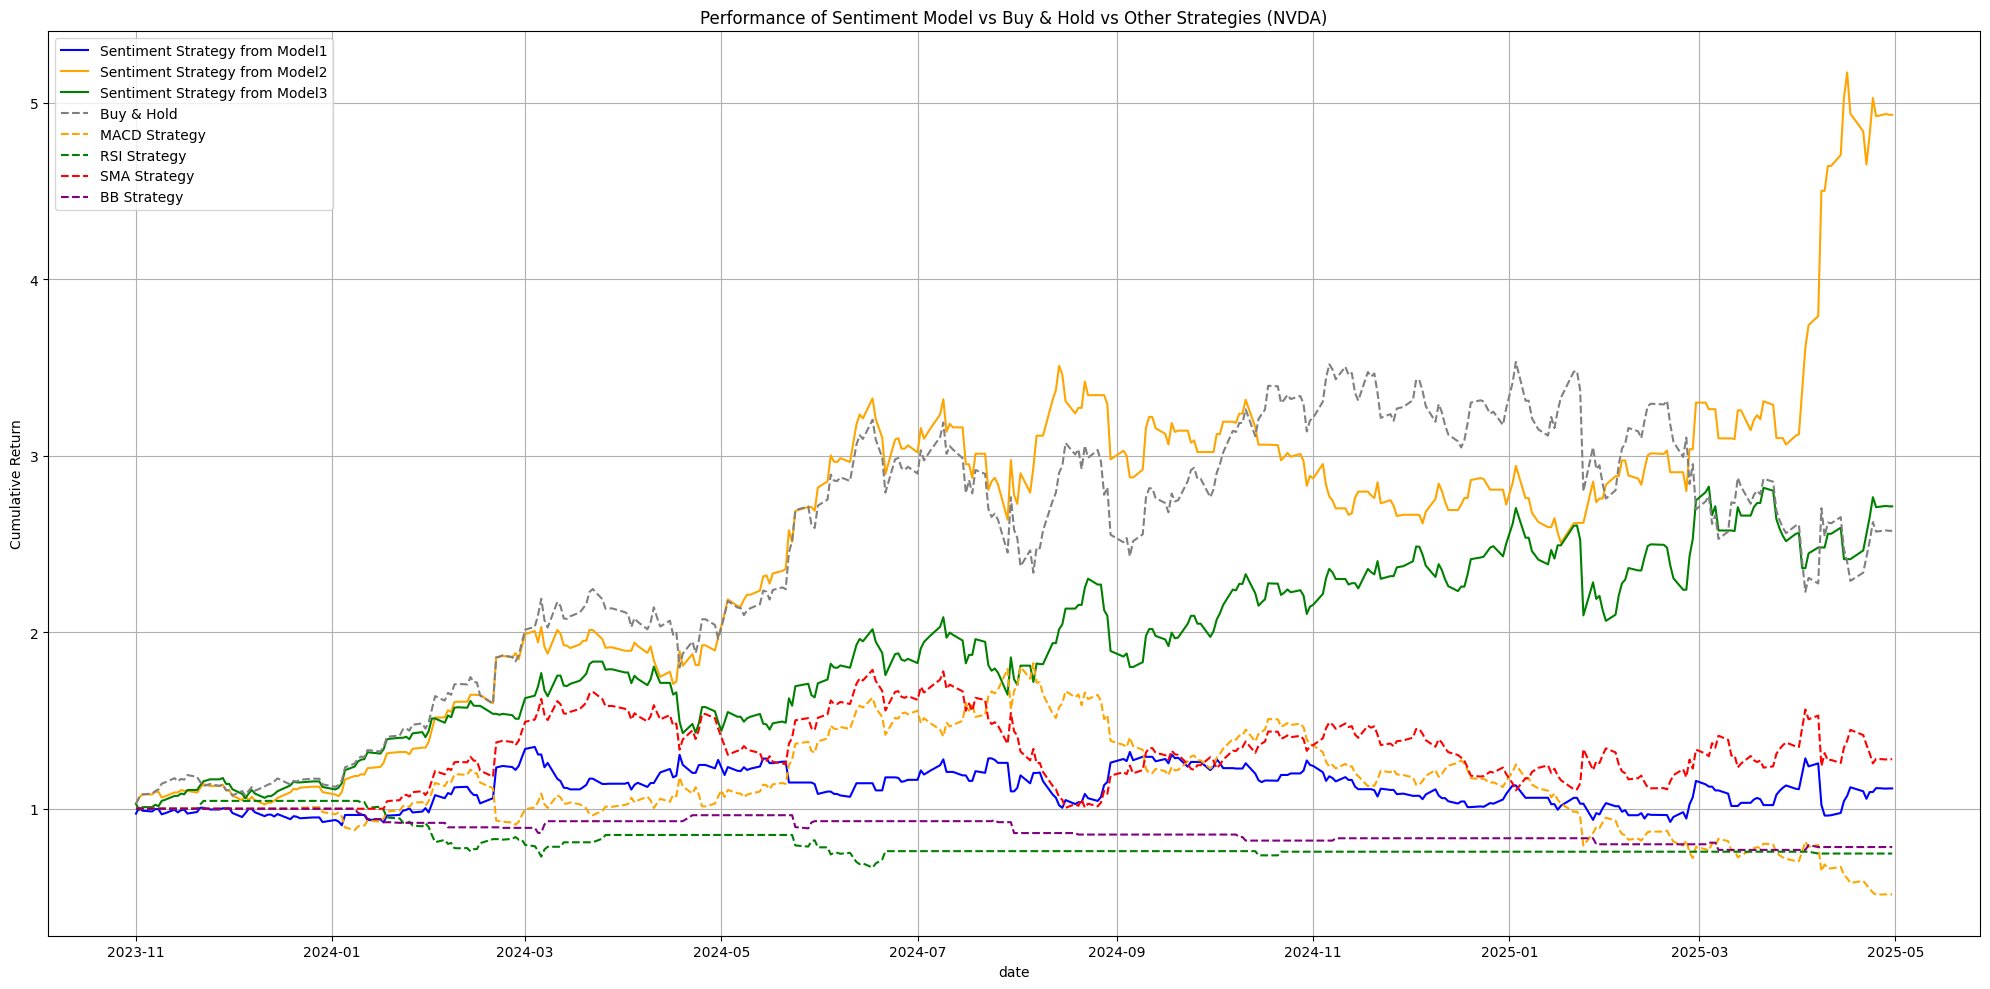

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(df['date'], df['Model1_Cumulative'], label='Sentiment Strategy from Model1', color='blue')
plt.plot(df['date'], df['Model2_Cumulative'], label='Sentiment Strategy from Model2', color='orange')
plt.plot(df['date'], df['Model3_Cumulative'], label='Sentiment Strategy from Model3', color='green')
plt.plot(df['date'], df['BuyHold_Cumulative'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(df['date'], df['MACD_Cumulative'], label='MACD Strategy', linestyle='--', color='orange')
plt.plot(df['date'], df['RSI_Cumulative'], label='RSI Strategy', linestyle='--', color='green')
plt.plot(df['date'], df['SMA_Cumulative'], label='SMA Strategy', linestyle='--', color='red')
plt.plot(df['date'], df['BB_Cumulative'], label='BB Strategy', linestyle='--', color='purple')
plt.title(f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({stock})")
plt.xlabel("date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import plotly.express as px
fig = px.line(df, x='date', y=['Model1_Cumulative', 'Model2_Cumulative', 'Model3_Cumulative', 'BuyHold_Cumulative', 'SMA_Cumulative', 'RSI_Cumulative', 'MACD_Cumulative', 'BB_Cumulative'],
              title=f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({stock})",
              labels={'value': 'Cumulative Return'},)
fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()

In [ ]:
def simulate_trading_strategy(x):
    initial_balance = 1000000
    capital = initial_balance
    position = 0

    for i in range(len(df)):
        if df[x][i] == 1 and position == 0:
            position = capital / df["Close"][i]
            capital = 0
            #print(f"Buying at {df['Close'][i]} on {df['date'][i]}")
        elif df[x][i] == -1 and position > 0:
            capital = position * df["Close"][i]
            position = 0
            #print(f"Selling at {df['Close'][i]} on {df['date'][i]}")
        elif df[x][i] == 0:
            #print(f"Holding at {df['Close'][i]} on {df['date'][i]}")
            pass

    final_value = capital if capital > 0 else position * df["Close"].iloc[-1]
    returns = (final_value - initial_balance) / initial_balance * 100
    print(f"Strategy from: {x}")
    print(f"Profit/Loss: {final_value - initial_balance:.2f}")
    print(f"Portfolio Return: {returns:.2f}% from {initial_balance} to {final_value:.2f} over {len(df)} days\n")

In [25]:
simulate_trading_strategy('sentiment1')
simulate_trading_strategy('sentiment2')
simulate_trading_strategy('sentiment3')
simulate_trading_strategy('sma_signal')
simulate_trading_strategy('rsi_signal')
simulate_trading_strategy('macd_signal_line')
simulate_trading_strategy('bb_signal')

Strategy from: sentiment1
Profit/Loss: 943402.08
Portfolio Return: 94.34% from 1000000 to 1943402.08 over 372 days

Strategy from: sentiment2
Profit/Loss: 2177838.15
Portfolio Return: 217.78% from 1000000 to 3177838.15 over 372 days

Strategy from: sentiment3
Profit/Loss: 1592841.15
Portfolio Return: 159.28% from 1000000 to 2592841.15 over 372 days

Strategy from: sma_signal
Profit/Loss: 1194512.69
Portfolio Return: 119.45% from 1000000 to 2194512.69 over 372 days

Strategy from: rsi_signal
Profit/Loss: 154914.65
Portfolio Return: 15.49% from 1000000 to 1154914.65 over 372 days

Strategy from: macd_signal_line
Profit/Loss: 335331.56
Portfolio Return: 33.53% from 1000000 to 1335331.56 over 372 days

Strategy from: bb_signal
Profit/Loss: 425764.81
Portfolio Return: 42.58% from 1000000 to 1425764.81 over 372 days



In [26]:
df["MA_5"] = df["Close"].rolling(window=5).mean()

sentiment1_corr = df["sentiment1"].corr(df["pct_change"])
sentiment2_corr = df["sentiment2"].corr(df["pct_change"])
sentiment3_corr = df["sentiment3"].corr(df["pct_change"])
ma_corr = df["MA_5"].corr(df["pct_change"])
sma_corr = df["SMA_20"].corr(df["pct_change"])
rsi_corr = df["RSI"].corr(df["pct_change"])
macd_corr = df["MACD"].corr(df["pct_change"])
bb_corr = df["bb_upper"].corr(df["pct_change"])

print(f"Sentiment1 Correlation: {sentiment1_corr:.2f}")
print(f"Sentiment2 Correlation: {sentiment2_corr:.2f}")
print(f"Sentiment3 Correlation: {sentiment3_corr:.2f}")
print(f"Moving Average Correlation: {ma_corr:.2f}")
print(f"SMA Correlation: {sma_corr:.2f}")
print(f"RSI Correlation: {rsi_corr:.2f}")
print(f"MACD Correlation: {macd_corr:.2f}")
print(f"Bollinger Bands Correlation: {bb_corr:.2f}")

Sentiment1 Correlation: 0.03
Sentiment2 Correlation: 0.12
Sentiment3 Correlation: 0.04
Moving Average Correlation: -0.12
SMA Correlation: -0.11
RSI Correlation: -0.03
MACD Correlation: -0.04
Bollinger Bands Correlation: -0.10


In [27]:
initial_price = df["Close"].iloc[0]
final_price = df["Close"].iloc[-1]

buy_hold_return = (final_price - initial_price) / initial_price * 100

print(f"Buy & Hold Return: {buy_hold_return:.2f}%")

Buy & Hold Return: 157.46%
